## Comando  para deixar iopub.data_rate maior que o padrão:
### 1 - Abra um jupyter notebook com o comando abaixo: 
### jupyter notebook --NotebookApp.iopub_data_rate_limit=1.0e10

## Pré-processamento

### Contando as sequências. Vou usar o software  seqkit

In [ ]:
#lncRNA
!grep ">" basesHumano/gencode.v38.lncRNA_transcripts.fasta | wc -l

In [ ]:
#RNA Transcritos
!grep ">" basesHumano/gencode.v38.pc_transcripts.fasta | wc -l

### Removendo os ruídos e dados duplicados

In [ ]:
#lncRNA
!seqkit rmdup -s < basesHumano/gencode.v38.lncRNA_transcripts.fasta > basesHumano/lncrna_noduplicado.fasta

In [ ]:
#RNA Transcritos
!seqkit rmdup -s < basesHumano/gencode.v38.pc_transcripts.fasta > basesHumano/rna_trancr_noduplicado.fasta

## Usando as funções de pré-processamento do MathFeature

### Eliminando ruídos como outras anotações(letras): k,N...

In [ ]:
#lncRNA
!python3 MathFeature/preprocessing/preprocessing.py -i basesHumano/lncrna_noduplicado.fasta -o basesHumano/lncrna_pre.fasta

In [ ]:
#RNA Transcritos
!python3 MathFeature/preprocessing/preprocessing.py -i basesHumano/rna_trancr_noduplicado.fasta -o basesHumano/rna_pre.fasta

### Recontanto as sequências

In [ ]:
#lncRNA
!grep ">" basesHumano/lncrna_pre.fasta | wc -l

In [ ]:
#mRNA Transcritos
!grep ">" basesHumano/rna_pre.fasta | wc -l

### Executando o sampling para deixa tudo igual

In [ ]:
#lncRNA
%run MathFeature/preprocessing/sampling.py -i basesHumano/rna_pre.fasta -o basesHumano/rna_presampling.fasta -p 97302

### Recontanto as sequências

In [ ]:
#lncRNA
!grep ">" basesHumano/lncrna_pre.fasta | wc -l

In [ ]:
#mRNA Transcritos
!grep ">" basesHumano/rna_presampling.fasta | wc -l

## Extração de características

### OPEN READING FRAME (ORF) DESCRIPTOR

In [ ]:
#lncRNA
%run MathFeature/methods/CodingClass.py -i basesHumano/lncrna_pre.fasta -o basesHumano/ORF_lncrna.csv -l lncRNA

In [ ]:
#mRNA
%run MathFeature/methods/CodingClass.py -i basesHumano/rna_presampling.fasta -o basesHumano/ORF_mrna.csv -l mRNA

### Fickett score

In [ ]:
#lncRNA
%run MathFeature/methods/FickettScore.py -i basesHumano/lncrna_pre.fasta -o basesHumano/FICKETT_lncrna.csv -l lncRNA -seq 1

In [ ]:
#mRNA
%run MathFeature/methods/FickettScore.py -i basesHumano/rna_presampling.fasta -o basesHumano/FICKETT_mrna.csv -l mRNA -seq 1

### Numerical Mapping and Fourier Transform

In [ ]:
#lncRNA
%run MathFeature/methods/FourierClass.py -i basesHumano/lncrna_pre.fasta -o basesHumano/FOURIER_lncrna.csv -l lncRNA -r 2

In [ ]:
#mRNA
%run MathFeature/methods/FourierClass.py -i basesHumano/rna_presampling.fasta -o basesHumano/FOURIER_mrna.csv -l mRNA -r 2

### Complex Networks -  desabilitei, pois está demorando mais de um dia para processar.

In [ ]:
#lncRNA
#%run MathFeature/methods/ComplexNetworksClass.py -i basesHumano/lncrna_pre.fasta -o basesHumano/CN_lncrna.csv -l lncRNA -k 3 -t 5

In [ ]:
#mRNA
#%run MathFeature/methods/ComplexNetworksClass.py -i basesHumano/rna_presampling.fasta -o basesHumano/CN_mrna.csv -l mRNA -k 3 -t 5

### Extração de características com o iFeature

In [ ]:
!python iFeature/iFeature.py --file basesHumano/lncrna_pre.fasta --type AAC

In [ ]:
!python iFeature/iFeature.py --file basesHumano/rna_presampling.fasta --type AAC

In [ ]:
import pandas as pd

In [ ]:
dflncRNA = pd.read_csv('basesHumano/AAC_mod_lncRNA.csv',sep=',')

In [ ]:
dflncRNA.head()

In [ ]:
dflncRNA['label'] = 'lncRNA'

In [ ]:
display(dflncRNA)

In [ ]:
dflncRNA.to_csv('AAC_lncRNA.csv',index=False,sep=',')

In [ ]:
dfmRNA = pd.read_csv('basesHumano/AAC_mod_mRNA.csv',sep=',')

In [ ]:
display(dfmRNA)

In [ ]:
dfmRNA['label'] = 'mRNA'

In [ ]:
display(dfmRNA)

In [ ]:
dfmRNA.to_csv('AAC_mRNA.csv',index=False,sep=',')

### Concatenando os datasets - iFeature + MathFeature (AAC + FOURIER + ORF)

In [ ]:
%run MathFeature/preprocessing/concatenate.py -n 3 -o basesHumano/lncRNA.csv

In [ ]:
%run MathFeature/preprocessing/concatenate.py -n 3 -o basesHumano/mRNA.csv

## Divisão em treino e teste

In [3]:
#importando as bibliotecas
import os 
import pandas
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import cohen_kappa_score,confusion_matrix, accuracy_score,  precision_score, recall_score, f1_score, roc_auc_score,roc_curve,auc,r2_score
from sklearn.model_selection import KFold 
from sklearn.model_selection import cross_val_score 
from sklearn.model_selection import cross_val_predict 
from imblearn.metrics import specificity_score
import matplotlib.pyplot  as pyplot

In [ ]:
#Função para dividir em treino e teste
def split(finput, test_rate):
    dataset = pandas.read_csv(finput)
    X = dataset.iloc[:, :-1]
    y = dataset.iloc[:, -1]
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = test_rate)
    train = pandas.concat([X_train, y_train], axis=1)
    test = pandas.concat([X_test, y_test], axis=1)
    
    trainData = os.path.splitext(finput)[0]+"_train"+os.path.splitext(finput)[1]
    testData = os.path.splitext(finput)[0]+"_test"+os.path.splitext(finput)[1]
    train.to_csv(trainData, index=False)
    test.to_csv(testData, index=False)    
    return          

In [ ]:
# Aplica a divisão treino e teste nas bases mRNA e lncRNA
split('basesHumano/mRNA.csv',0.3)
split('basesHumano/lncRNA.csv',0.3)

In [4]:
# carrega a base de dados treino lncRNA e mRNA
lncRNA_data = pandas.read_csv('basesHumano/lncRNA_train.csv')
mRNA_data = pandas.read_csv('basesHumano/mRNA_train.csv')
dadosTreino = pandas.concat([lncRNA_data,mRNA_data])

In [5]:
dadosTreino.columns

Index(['nameseq', 'A', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'K', 'L', 'M', 'N',
       'P', 'Q', 'R', 'S', 'T', 'V', 'W', 'Y', 'average', 'median', 'maximum',
       'minimum', 'peak', 'none_levated_peak', 'sample_standard_deviation',
       'population_standard_deviation', 'percentile15', 'percentile25',
       'percentile50', 'percentile75', 'amplitude', 'variance',
       'interquartile_range', 'semi_interquartile_range',
       'coefficient_of_variation', 'skewness', 'kurtosis',
       'maximum_ORF_length', 'minimum_ORF_length', 'std_ORF_length',
       'average_ORF_length', 'cv_ORF_length', 'maximum_GC_content_ORF',
       'minimum_GC_content_ORF', 'std_GC_content_ORF',
       'average_GC_content_ORF', 'cv_GC_content_ORF', 'label'],
      dtype='object')

In [6]:
display(dadosTreino)

,nameseq,A,C,D,E,F,G,H,I,K,...,minimum_ORF_length,std_ORF_length,average_ORF_length,cv_ORF_length,maximum_GC_content_ORF,minimum_GC_content_ORF,std_GC_content_ORF,average_GC_content_ORF,cv_GC_content_ORF,label
0,ENST00000624128.2|ENSG00000203875.13|OTTHUMG00...,0.273009,0.199536,0.0,0.0,0.0,0.278422,0.0,0.0,0.0,...,9,48.826094,53.250000,0.916922,58.823529,11.111111,13.563062,38.250925,0.354581,lncRNA
1,ENST00000657993.1|ENSG00000239523.6|OTTHUMG000...,0.323664,0.206107,0.0,0.0,0.0,0.225954,0.0,0.0,0.0,...,9,54.977814,67.200000,0.818122,44.444444,31.428571,5.450845,38.166056,0.142819,lncRNA
2,ENST00000553454.1|ENSG00000215256.4|OTTHUMG000...,0.239946,0.266086,0.0,0.0,0.0,0.280161,0.0,0.0,0.0,...,9,61.747470,89.500000,0.689916,71.345029,38.095238,9.501427,49.701641,0.191169,lncRNA
3,ENST00000528133.1|ENSG00000254676.1|OTTHUMG000...,0.264088,0.184530,0.0,0.0,0.0,0.205525,0.0,0.0,0.0,...,9,45.753688,48.000000,0.953202,48.387097,22.222222,7.430612,30.658103,0.242370,lncRNA
4,ENST00000669022.1|ENSG00000275830.2|OTTHUMG000...,0.261066,0.239386,0.0,0.0,0.0,0.222222,0.0,0.0,0.0,...,6,34.125650,30.200000,1.129988,63.157895,16.666667,11.432097,40.144412,0.284774,lncRNA
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
68106,ENST00000368092.7|ENSG00000162723.10|OTTHUMG00...,0.247350,0.270907,0.0,0.0,0.0,0.253239,0.0,0.0,0.0,...,18,201.868769,149.000000,1.354824,56.000000,38.888889,5.424358,49.936866,0.108624,mRNA
68107,ENST00000253099.11|ENSG00000105364.14|OTTHUMG0...,0.192939,0.330870,0.0,0.0,0.0,0.305419,0.0,0.0,0.0,...,6,374.642830,307.500000,1.218351,65.064103,33.333333,12.481002,54.264172,0.230004,mRNA
68108,ENST00000648544.1|ENSG00000164543.7|OTTHUMG000...,0.296316,0.207688,0.0,0.0,0.0,0.256273,0.0,0.0,0.0,...,6,266.955784,125.368421,2.129370,55.172414,20.833333,7.740153,38.693437,0.200038,mRNA
68109,ENST00000457054.6|ENSG00000170248.15|OTTHUMG00...,0.306105,0.192385,0.0,0.0,0.0,0.200604,0.0,0.0,0.0,...,6,305.954888,85.356164,3.584450,58.333333,13.333333,9.018525,32.991789,0.273357,mRNA


In [7]:
#Remove column nameseq
dadosTreino.drop(columns='nameseq', inplace=True)

In [8]:
#Vamos verificar
dadosTreino.columns

Index(['A', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'K', 'L', 'M', 'N', 'P', 'Q',
       'R', 'S', 'T', 'V', 'W', 'Y', 'average', 'median', 'maximum', 'minimum',
       'peak', 'none_levated_peak', 'sample_standard_deviation',
       'population_standard_deviation', 'percentile15', 'percentile25',
       'percentile50', 'percentile75', 'amplitude', 'variance',
       'interquartile_range', 'semi_interquartile_range',
       'coefficient_of_variation', 'skewness', 'kurtosis',
       'maximum_ORF_length', 'minimum_ORF_length', 'std_ORF_length',
       'average_ORF_length', 'cv_ORF_length', 'maximum_GC_content_ORF',
       'minimum_GC_content_ORF', 'std_GC_content_ORF',
       'average_GC_content_ORF', 'cv_GC_content_ORF', 'label'],
      dtype='object')

In [9]:
#Verificar valores nulos
dadosTreino.isnull().sum()

A                                0
C                                0
D                                0
E                                0
F                                0
G                                0
H                                0
I                                0
K                                0
L                                0
M                                0
N                                0
P                                0
Q                                0
R                                0
S                                0
T                                0
V                                0
W                                0
Y                                0
average                          0
median                           0
maximum                          0
minimum                          0
peak                             0
none_levated_peak                0
sample_standard_deviation        0
population_standard_deviation    0
percentile15        

In [10]:
#Fazendo uma cópia dos dados
dadosTreinoAux = dadosTreino.copy()

In [11]:
display(dadosTreino)

,A,C,D,E,F,G,H,I,K,L,...,minimum_ORF_length,std_ORF_length,average_ORF_length,cv_ORF_length,maximum_GC_content_ORF,minimum_GC_content_ORF,std_GC_content_ORF,average_GC_content_ORF,cv_GC_content_ORF,label
0,0.273009,0.199536,0.0,0.0,0.0,0.278422,0.0,0.0,0.0,0.0,...,9,48.826094,53.250000,0.916922,58.823529,11.111111,13.563062,38.250925,0.354581,lncRNA
1,0.323664,0.206107,0.0,0.0,0.0,0.225954,0.0,0.0,0.0,0.0,...,9,54.977814,67.200000,0.818122,44.444444,31.428571,5.450845,38.166056,0.142819,lncRNA
2,0.239946,0.266086,0.0,0.0,0.0,0.280161,0.0,0.0,0.0,0.0,...,9,61.747470,89.500000,0.689916,71.345029,38.095238,9.501427,49.701641,0.191169,lncRNA
3,0.264088,0.184530,0.0,0.0,0.0,0.205525,0.0,0.0,0.0,0.0,...,9,45.753688,48.000000,0.953202,48.387097,22.222222,7.430612,30.658103,0.242370,lncRNA
4,0.261066,0.239386,0.0,0.0,0.0,0.222222,0.0,0.0,0.0,0.0,...,6,34.125650,30.200000,1.129988,63.157895,16.666667,11.432097,40.144412,0.284774,lncRNA
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
68106,0.247350,0.270907,0.0,0.0,0.0,0.253239,0.0,0.0,0.0,0.0,...,18,201.868769,149.000000,1.354824,56.000000,38.888889,5.424358,49.936866,0.108624,mRNA
68107,0.192939,0.330870,0.0,0.0,0.0,0.305419,0.0,0.0,0.0,0.0,...,6,374.642830,307.500000,1.218351,65.064103,33.333333,12.481002,54.264172,0.230004,mRNA
68108,0.296316,0.207688,0.0,0.0,0.0,0.256273,0.0,0.0,0.0,0.0,...,6,266.955784,125.368421,2.129370,55.172414,20.833333,7.740153,38.693437,0.200038,mRNA
68109,0.306105,0.192385,0.0,0.0,0.0,0.200604,0.0,0.0,0.0,0.0,...,6,305.954888,85.356164,3.584450,58.333333,13.333333,9.018525,32.991789,0.273357,mRNA


## Normalização dos dados treino

In [12]:
#Transform categorical in binary class values
dicionario = {'mRNA':0,'lncRNA':1}
dadosTreino['label'] = dadosTreino['label'].map(dicionario) 

In [13]:
dadosTreino.columns

Index(['A', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'K', 'L', 'M', 'N', 'P', 'Q',
       'R', 'S', 'T', 'V', 'W', 'Y', 'average', 'median', 'maximum', 'minimum',
       'peak', 'none_levated_peak', 'sample_standard_deviation',
       'population_standard_deviation', 'percentile15', 'percentile25',
       'percentile50', 'percentile75', 'amplitude', 'variance',
       'interquartile_range', 'semi_interquartile_range',
       'coefficient_of_variation', 'skewness', 'kurtosis',
       'maximum_ORF_length', 'minimum_ORF_length', 'std_ORF_length',
       'average_ORF_length', 'cv_ORF_length', 'maximum_GC_content_ORF',
       'minimum_GC_content_ORF', 'std_GC_content_ORF',
       'average_GC_content_ORF', 'cv_GC_content_ORF', 'label'],
      dtype='object')

In [14]:
#dadosTreino.iloc[:,20:49]
from sklearn.preprocessing import MinMaxScaler

# create a scaler object
scaler = MinMaxScaler()
# fit and transform the data
cols = dadosTreino.iloc[:, 20:49].columns
dadosTreino[cols] = pandas.DataFrame(scaler.fit_transform(dadosTreino.iloc[:, 20:49]), columns=dadosTreino.iloc[:, 20:49].columns)

In [15]:
dadosTreino

,A,C,D,E,F,G,H,I,K,L,...,minimum_ORF_length,std_ORF_length,average_ORF_length,cv_ORF_length,maximum_GC_content_ORF,minimum_GC_content_ORF,std_GC_content_ORF,average_GC_content_ORF,cv_GC_content_ORF,label
0,0.273009,0.199536,0.0,0.0,0.0,0.278422,0.0,0.0,0.0,0.0,...,0.006818,0.015199,0.039227,0.041929,0.641711,0.130952,0.474167,0.450814,0.493489,1
1,0.323664,0.206107,0.0,0.0,0.0,0.225954,0.0,0.0,0.0,0.0,...,0.006818,0.017114,0.049503,0.037411,0.484848,0.370408,0.190562,0.449814,0.198769,1
2,0.239946,0.266086,0.0,0.0,0.0,0.280161,0.0,0.0,0.0,0.0,...,0.006818,0.019222,0.065930,0.031549,0.778309,0.448980,0.332171,0.585769,0.266060,1
3,0.264088,0.184530,0.0,0.0,0.0,0.205525,0.0,0.0,0.0,0.0,...,0.006818,0.014243,0.035359,0.043588,0.527859,0.261905,0.259775,0.361328,0.337319,1
4,0.261066,0.239386,0.0,0.0,0.0,0.222222,0.0,0.0,0.0,0.0,...,0.004545,0.010623,0.022247,0.051673,0.688995,0.196429,0.399668,0.473131,0.396335,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
68106,0.247350,0.270907,0.0,0.0,0.0,0.253239,0.0,0.0,0.0,0.0,...,0.006818,0.010758,0.032747,0.035548,0.648221,0.235714,0.372699,0.521885,0.335064,0
68107,0.192939,0.330870,0.0,0.0,0.0,0.305419,0.0,0.0,0.0,0.0,...,0.006818,0.011110,0.038999,0.030827,0.539589,0.245536,0.273451,0.420313,0.305247,0
68108,0.296316,0.207688,0.0,0.0,0.0,0.256273,0.0,0.0,0.0,0.0,...,0.004545,0.010693,0.033763,0.034270,0.631579,0.196429,0.441372,0.413964,0.500249,0
68109,0.306105,0.192385,0.0,0.0,0.0,0.200604,0.0,0.0,0.0,0.0,...,0.006818,0.006282,0.018785,0.036189,0.606061,0.471429,0.194890,0.571280,0.160061,0


In [16]:
#Divide a base entre os previsores e classe
colunas = dadosTreino.columns.drop('label')

In [17]:
# Gera os previsores e classe (X e y)
X = dadosTreino[colunas].values
y = dadosTreino['label']

## Dados de Teste

In [18]:
# carrega a base de dados teste lncRNA e mRNA
lncRNA_data_t = pandas.read_csv('basesHumano/lncRNA_test.csv')
mRNA_data_t = pandas.read_csv('basesHumano/mRNA_test.csv')
dadosTeste = pandas.concat([lncRNA_data_t,mRNA_data_t])

In [19]:
dadosTeste

,nameseq,A,C,D,E,F,G,H,I,K,...,minimum_ORF_length,std_ORF_length,average_ORF_length,cv_ORF_length,maximum_GC_content_ORF,minimum_GC_content_ORF,std_GC_content_ORF,average_GC_content_ORF,cv_GC_content_ORF,label
0,ENST00000662662.1|ENSG00000255760.2|OTTHUMG000...,0.304718,0.249807,0.0,0.0,0.0,0.228925,0.0,0.0,0.0,...,18,81.694553,83.000000,0.984272,62.500000,38.888889,6.006221,48.185650,0.124648,lncRNA
1,ENST00000670263.1|ENSG00000241472.7|OTTHUMG000...,0.296918,0.209130,0.0,0.0,0.0,0.196254,0.0,0.0,0.0,...,6,48.063540,47.581395,1.010133,57.692308,8.333333,11.198298,37.150870,0.301428,lncRNA
2,ENST00000414989.2|ENSG00000224192.2|OTTHUMG000...,0.228037,0.261682,0.0,0.0,0.0,0.241121,0.0,0.0,0.0,...,6,41.173224,54.375000,0.757209,58.333333,33.333333,7.625398,46.705952,0.163264,lncRNA
3,ENST00000656534.1|ENSG00000226995.9|OTTHUMG000...,0.239715,0.257120,0.0,0.0,0.0,0.265823,0.0,0.0,0.0,...,6,69.193641,67.800000,1.020555,60.000000,26.666667,9.253747,49.838720,0.185674,lncRNA
4,ENST00000656913.1|ENSG00000267712.6|OTTHUMG000...,0.319322,0.205144,0.0,0.0,0.0,0.216437,0.0,0.0,0.0,...,6,58.135080,69.750000,0.833478,61.538462,25.000000,7.593501,40.751077,0.186339,lncRNA
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29186,ENST00000503281.6|ENSG00000164904.18|OTTHUMG00...,0.260406,0.214514,0.0,0.0,0.0,0.289221,0.0,0.0,0.0,...,9,21.330729,31.000000,0.688088,60.416667,22.222222,9.840077,46.713802,0.210646,mRNA
29187,ENST00000303645.10|ENSG00000170262.13|OTTHUMG0...,0.237634,0.310753,0.0,0.0,0.0,0.253763,0.0,0.0,0.0,...,6,162.172244,135.857143,1.193697,64.341085,33.333333,10.030041,51.329949,0.195403,mRNA
29188,ENST00000526322.5|ENSG00000149294.17|OTTHUMG00...,0.257143,0.269048,0.0,0.0,0.0,0.239683,0.0,0.0,0.0,...,21,166.349662,149.700000,1.111220,60.185185,38.461538,7.148636,50.235307,0.142303,mRNA
29189,ENST00000586262.5|ENSG00000091164.13|OTTHUMG00...,0.303869,0.166902,0.0,0.0,0.0,0.181870,0.0,0.0,0.0,...,6,118.819495,65.265306,1.820561,47.222222,8.333333,8.372529,32.985070,0.253828,mRNA


In [20]:
#Remove column nameseq
dadosTeste.drop(columns='nameseq', inplace=True)

In [21]:
dadosTeste

,A,C,D,E,F,G,H,I,K,L,...,minimum_ORF_length,std_ORF_length,average_ORF_length,cv_ORF_length,maximum_GC_content_ORF,minimum_GC_content_ORF,std_GC_content_ORF,average_GC_content_ORF,cv_GC_content_ORF,label
0,0.304718,0.249807,0.0,0.0,0.0,0.228925,0.0,0.0,0.0,0.0,...,18,81.694553,83.000000,0.984272,62.500000,38.888889,6.006221,48.185650,0.124648,lncRNA
1,0.296918,0.209130,0.0,0.0,0.0,0.196254,0.0,0.0,0.0,0.0,...,6,48.063540,47.581395,1.010133,57.692308,8.333333,11.198298,37.150870,0.301428,lncRNA
2,0.228037,0.261682,0.0,0.0,0.0,0.241121,0.0,0.0,0.0,0.0,...,6,41.173224,54.375000,0.757209,58.333333,33.333333,7.625398,46.705952,0.163264,lncRNA
3,0.239715,0.257120,0.0,0.0,0.0,0.265823,0.0,0.0,0.0,0.0,...,6,69.193641,67.800000,1.020555,60.000000,26.666667,9.253747,49.838720,0.185674,lncRNA
4,0.319322,0.205144,0.0,0.0,0.0,0.216437,0.0,0.0,0.0,0.0,...,6,58.135080,69.750000,0.833478,61.538462,25.000000,7.593501,40.751077,0.186339,lncRNA
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29186,0.260406,0.214514,0.0,0.0,0.0,0.289221,0.0,0.0,0.0,0.0,...,9,21.330729,31.000000,0.688088,60.416667,22.222222,9.840077,46.713802,0.210646,mRNA
29187,0.237634,0.310753,0.0,0.0,0.0,0.253763,0.0,0.0,0.0,0.0,...,6,162.172244,135.857143,1.193697,64.341085,33.333333,10.030041,51.329949,0.195403,mRNA
29188,0.257143,0.269048,0.0,0.0,0.0,0.239683,0.0,0.0,0.0,0.0,...,21,166.349662,149.700000,1.111220,60.185185,38.461538,7.148636,50.235307,0.142303,mRNA
29189,0.303869,0.166902,0.0,0.0,0.0,0.181870,0.0,0.0,0.0,0.0,...,6,118.819495,65.265306,1.820561,47.222222,8.333333,8.372529,32.985070,0.253828,mRNA


In [22]:
#Transform categorical in binary class values
dicionario = {'mRNA':0,'lncRNA':1}
dadosTeste['label'] = dadosTeste['label'].map(dicionario) 

In [23]:
dadosTeste

,A,C,D,E,F,G,H,I,K,L,...,minimum_ORF_length,std_ORF_length,average_ORF_length,cv_ORF_length,maximum_GC_content_ORF,minimum_GC_content_ORF,std_GC_content_ORF,average_GC_content_ORF,cv_GC_content_ORF,label
0,0.304718,0.249807,0.0,0.0,0.0,0.228925,0.0,0.0,0.0,0.0,...,18,81.694553,83.000000,0.984272,62.500000,38.888889,6.006221,48.185650,0.124648,1
1,0.296918,0.209130,0.0,0.0,0.0,0.196254,0.0,0.0,0.0,0.0,...,6,48.063540,47.581395,1.010133,57.692308,8.333333,11.198298,37.150870,0.301428,1
2,0.228037,0.261682,0.0,0.0,0.0,0.241121,0.0,0.0,0.0,0.0,...,6,41.173224,54.375000,0.757209,58.333333,33.333333,7.625398,46.705952,0.163264,1
3,0.239715,0.257120,0.0,0.0,0.0,0.265823,0.0,0.0,0.0,0.0,...,6,69.193641,67.800000,1.020555,60.000000,26.666667,9.253747,49.838720,0.185674,1
4,0.319322,0.205144,0.0,0.0,0.0,0.216437,0.0,0.0,0.0,0.0,...,6,58.135080,69.750000,0.833478,61.538462,25.000000,7.593501,40.751077,0.186339,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29186,0.260406,0.214514,0.0,0.0,0.0,0.289221,0.0,0.0,0.0,0.0,...,9,21.330729,31.000000,0.688088,60.416667,22.222222,9.840077,46.713802,0.210646,0
29187,0.237634,0.310753,0.0,0.0,0.0,0.253763,0.0,0.0,0.0,0.0,...,6,162.172244,135.857143,1.193697,64.341085,33.333333,10.030041,51.329949,0.195403,0
29188,0.257143,0.269048,0.0,0.0,0.0,0.239683,0.0,0.0,0.0,0.0,...,21,166.349662,149.700000,1.111220,60.185185,38.461538,7.148636,50.235307,0.142303,0
29189,0.303869,0.166902,0.0,0.0,0.0,0.181870,0.0,0.0,0.0,0.0,...,6,118.819495,65.265306,1.820561,47.222222,8.333333,8.372529,32.985070,0.253828,0


## Normalização dos dados Teste

In [24]:
scaler_t = MinMaxScaler()
# fit and transform the data
cols = dadosTeste.iloc[:, 20:49].columns
dadosTeste[cols] = pandas.DataFrame(scaler_t.fit_transform(dadosTeste.iloc[:, 20:49]), columns=dadosTeste.iloc[:, 20:49].columns)

In [25]:
dadosTeste

,A,C,D,E,F,G,H,I,K,L,...,minimum_ORF_length,std_ORF_length,average_ORF_length,cv_ORF_length,maximum_GC_content_ORF,minimum_GC_content_ORF,std_GC_content_ORF,average_GC_content_ORF,cv_GC_content_ORF,label
0,0.304718,0.249807,0.0,0.0,0.0,0.228925,0.0,0.0,0.0,0.0,...,0.014118,0.025737,0.065098,0.045834,0.692935,0.458333,0.201771,0.567902,0.171684,1
1,0.296918,0.209130,0.0,0.0,0.0,0.196254,0.0,0.0,0.0,0.0,...,0.004706,0.015142,0.037319,0.047039,0.639632,0.098214,0.376193,0.437850,0.415174,1
2,0.228037,0.261682,0.0,0.0,0.0,0.241121,0.0,0.0,0.0,0.0,...,0.004706,0.012971,0.042647,0.035261,0.646739,0.392857,0.256166,0.550463,0.224873,1
3,0.239715,0.257120,0.0,0.0,0.0,0.265823,0.0,0.0,0.0,0.0,...,0.004706,0.021799,0.053176,0.047524,0.665217,0.314286,0.310868,0.587385,0.255739,1
4,0.319322,0.205144,0.0,0.0,0.0,0.216437,0.0,0.0,0.0,0.0,...,0.004706,0.018315,0.054706,0.038812,0.682274,0.294643,0.255094,0.480281,0.256655,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29186,0.260406,0.214514,0.0,0.0,0.0,0.289221,0.0,0.0,0.0,0.0,...,0.004706,0.015951,0.052941,0.034930,0.739130,0.392857,0.432938,0.560395,0.373315,0
29187,0.237634,0.310753,0.0,0.0,0.0,0.253763,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0
29188,0.257143,0.269048,0.0,0.0,0.0,0.239683,0.0,0.0,0.0,0.0,...,0.011765,0.017307,0.041569,0.048268,0.471196,0.261905,0.251306,0.397664,0.305374,0
29189,0.303869,0.166902,0.0,0.0,0.0,0.181870,0.0,0.0,0.0,0.0,...,0.004706,0.010174,0.038503,0.030632,0.501553,0.261905,0.203249,0.420243,0.233708,0


In [26]:
# Gera os previsores e classe (X e y)
X_teste = dadosTeste[colunas].values
y_teste = dadosTeste['label']

In [27]:
print(X_teste)

[[0.30471771 0.24980665 0.         ... 0.20177149 0.56790231 0.1716843 ]
 [0.29691767 0.20912993 0.         ... 0.37619281 0.43784954 0.41517387]
 [0.22803738 0.26168224 0.         ... 0.25616571 0.55046301 0.22487297]
 ...
 [0.25714286 0.26904762 0.         ... 0.25130635 0.39766393 0.30537373]
 [0.30386896 0.16690201 0.         ... 0.20324946 0.42024313 0.23370779]
 [0.32887795 0.16602181 0.         ... 0.32336194 0.45560438 0.34296154]]


In [28]:
print(y_teste)

0        1
1        1
2        1
3        1
4        1
        ..
29186    0
29187    0
29188    0
29189    0
29190    0
Name: label, Length: 58382, dtype: int64


In [29]:
# Exibe a quantidade de atributos
print("Columns size >>> %d"%len(colunas))

# Exibe o nome dos atributos
print(dadosTreino.columns)

Columns size >>> 49
Index(['A', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'K', 'L', 'M', 'N', 'P', 'Q',
       'R', 'S', 'T', 'V', 'W', 'Y', 'average', 'median', 'maximum', 'minimum',
       'peak', 'none_levated_peak', 'sample_standard_deviation',
       'population_standard_deviation', 'percentile15', 'percentile25',
       'percentile50', 'percentile75', 'amplitude', 'variance',
       'interquartile_range', 'semi_interquartile_range',
       'coefficient_of_variation', 'skewness', 'kurtosis',
       'maximum_ORF_length', 'minimum_ORF_length', 'std_ORF_length',
       'average_ORF_length', 'cv_ORF_length', 'maximum_GC_content_ORF',
       'minimum_GC_content_ORF', 'std_GC_content_ORF',
       'average_GC_content_ORF', 'cv_GC_content_ORF', 'label'],
      dtype='object')


In [30]:
print(X.shape, y.shape, X_teste.shape, y_teste.shape)

(136222, 49) (136222,) (58382, 49) (58382,)


## Aplica o modelo de predição com RandomForest sem o Feature Importance

In [31]:
from sklearn.ensemble import RandomForestClassifier
# instancia um DecisionTreeClassifier
clf_rf = RandomForestClassifier(n_estimators = 10, criterion = 'entropy',random_state=123) 
# treina o DT
clf_rf.fit(X, y)

y_pred = clf_rf.predict(X_teste)
#print(y_pred)

 # gerar score baseado na acurácia
acuracidade = round(accuracy_score(y_teste,y_pred)*100,2)
print(acuracidade)

69.04


## Aplica o modelo de predição com RandomForest e Wrapper

In [32]:
from sklearn.feature_selection import RFE

clf_rf_2 = RandomForestClassifier(n_estimators = 10, criterion = 'entropy',random_state=123)      
rfe = RFE(estimator=clf_rf_2,n_features_to_select=10,step=1)
rfe = rfe.fit(X,y)

In [33]:
#Armazena a nova dimensão do vetor de características
features = rfe.fit_transform(X,y)

In [34]:
#Verifica a quantidade
print(features.shape)

(136222, 10)


## Obtendo as 10 melhores features

In [35]:
temp = pandas.Series(rfe.support_,index = colunas)
wrapperApproach = temp[temp==True].index
print(wrapperApproach)

Index(['A', 'C', 'G', 'T', 'peak', 'none_levated_peak', 'average_ORF_length',
       'maximum_GC_content_ORF', 'std_GC_content_ORF',
       'average_GC_content_ORF'],
      dtype='object')


In [36]:
#Predicao sem validação cruzada
y_pred = rfe.predict(X_teste)
acuracidade = round(accuracy_score(y_teste,y_pred)*100,2)
print(acuracidade)

87.47


In [37]:
rf_pred = rfe.predict(X_teste)

## Calculando as métricas

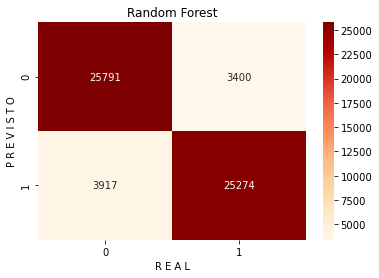

In [38]:
#Matriz de confusão
from sklearn.metrics import confusion_matrix
import seaborn as sns
sns.heatmap(confusion_matrix(y_teste, rf_pred), cmap='OrRd', annot=True, fmt='2.0f')
plt.title('Random Forest')
plt.ylabel('P R E V I S T O')
plt.xlabel('R E A L')
plt.show()

In [39]:
#Acurácia, Sensibilidade positiva (VP/(VP+FN), Especificidade, Precisão, Recall, F1-Score
acuracia_rf = accuracy_score(y_teste,rf_pred)
especificidade_rf = specificity_score(y_teste,rf_pred)
precisao_rf = precision_score(y_teste,rf_pred)
recall_rf = recall_score(y_teste,y_pred)
f1Score_rf = f1_score(y_teste,rf_pred)
curva_roc_escore_rf = roc_auc_score(y_teste,rf_pred)
kappa_rf = cohen_kappa_score(y_teste,rf_pred)
print(f'Acurácia:{round(acuracia_rf,2)}')
print(f'Especificidade:{round(especificidade_rf,2)}')
print(f'Precisão:{round(precisao_rf,2)}')
print(f'Recall ou Sensibilidade:{round(recall_rf,2)}')
print(f'F1-Score:{round(f1Score_rf,2)}')
print(f'Kappa:{round(kappa_rf,2)}')
print(f'Curva ROC:{round(curva_roc_escore_rf,2)}')

Acurácia:0.87
Especificidade:0.88
Precisão:0.88
Recall ou Sensibilidade:0.87
F1-Score:0.87
Kappa:0.75
Curva ROC:0.87


## Aplica o modelo de predição com Regressão Logística e Wrapper

In [40]:
from sklearn.linear_model import LogisticRegression
clf_rl = LogisticRegression(max_iter=2000)
rfe_rl = RFE(clf_rl,n_features_to_select=10,step=1)
fit_rl = rfe_rl.fit(X,y)

In [41]:
#Armazena a nova dimensão do vetor de características
features_rl = fit_rl.fit_transform(X,y)

In [42]:
#Verifica a quantidade
print(features_rl.shape)

(136222, 10)


## Exibindo as 10 melhores features

In [43]:
temp_rl = pandas.Series(fit_rl.support_,index = colunas)
wrapperApproach_rl = temp_rl[temp_rl==True].index
print(wrapperApproach_rl)

Index(['A', 'C', 'T', 'none_levated_peak', 'kurtosis',
       'maximum_GC_content_ORF', 'minimum_GC_content_ORF',
       'std_GC_content_ORF', 'average_GC_content_ORF', 'cv_GC_content_ORF'],
      dtype='object')


In [44]:
#Predicao sem validação cruzada
y_pred_rl = fit_rl.predict(X_teste)
acuracidade_rl = round(accuracy_score(y_teste,y_pred_rl)*100,2)
print(acuracidade_rl)

50.11


In [45]:
rl_pred = fit_rl.predict(X_teste)

## Calculando as métricas

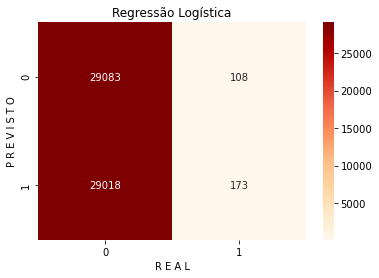

In [46]:
#Matriz de confusão
sns.heatmap(confusion_matrix(y_teste, rl_pred), cmap='OrRd', annot=True, fmt='2.0f')
plt.title('Regressão Logística')
plt.ylabel('P R E V I S T O')
plt.xlabel('R E A L')
plt.show()

In [47]:
#Acurácia, Sensibilidade positiva (VP/(VP+FN), Especificidade, Precisão, Recall, F1-Score
acuracia_rl = accuracy_score(y_teste,rl_pred)
especificidade_rl = specificity_score(y_teste,rl_pred)
precisao_rl = precision_score(y_teste,rl_pred)
recall_rl = recall_score(y_teste,rl_pred)
f1Score_rl = f1_score(y_teste,rl_pred)
curva_roc_escore_rl = roc_auc_score(y_teste,rl_pred)
kappa_rl = cohen_kappa_score(y_teste,rl_pred)
print(f'Acurácia:{round(acuracia_rl,2)}')
print(f'Especificidade:{round(especificidade_rl,2)}')
print(f'Precisão:{round(precisao_rl,2)}')
print(f'Recall ou Sensibilidade:{round(recall_rl,2)}')
print(f'F1-Score:{round(f1Score_rl,2)}')
print(f'Kappa:{round(kappa_rl,2)}')
print(f'Curva ROC:{round(curva_roc_escore_rl,2)}')

Acurácia:0.5
Especificidade:1.0
Precisão:0.62
Recall ou Sensibilidade:0.01
F1-Score:0.01
Kappa:0.0
Curva ROC:0.5


## Curva ROC

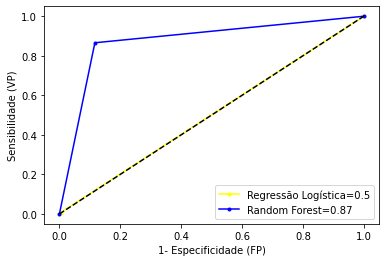

In [48]:
rfp_rl, rvp_rl,lim1 = roc_curve(y_teste,rl_pred)
rfp_rf, rvp_rf,lim2 = roc_curve(y_teste,rf_pred)
pyplot.plot(rfp_rl, rvp_rl, marker='.', label='Regressão Logística='+str(round(curva_roc_escore_rl,2)),color='yellow')
pyplot.plot(rfp_rf, rvp_rf, marker='.', label='Random Forest='+str(round(curva_roc_escore_rf,2)),color='blue')
pyplot.plot([0, 1], [0, 1], color='black', linestyle='--')
# alterando o nome dos eixos
pyplot.xlabel('1- Especificidade (FP)')
pyplot.ylabel('Sensibilidade (VP)')
pyplot.legend()
# Mostrando o gráfico
pyplot.show()

## Análise por Feature Importance (Método Wrapper)

Feature A - score 0.12039
Feature C - score 0.13420
Feature G - score 0.12441
Feature T - score 0.10071
Feature peak - score 0.05740
Feature none_levated_peak - score 0.17094
Feature average_ORF_length - score 0.05462
Feature maximum_GC_content_ORF - score 0.05104
Feature std_GC_content_ORF - score 0.05054
Feature average_GC_content_ORF - score 0.13576


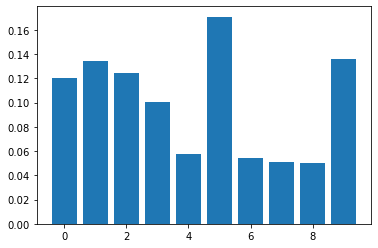

In [49]:
# decision tree for feature importance on a regression problem
# define the model
featuresList = wrapperApproach.tolist()
model = RandomForestClassifier(n_estimators = 10, criterion = 'entropy',random_state=43) 
# fit the model
model.fit(features, y)
# get importance
importance = model.feature_importances_
# summarize feature importance
for i,v in enumerate(importance):
    print('Feature %s - score %.5f' % (featuresList[i], v) )
    #print('Feature: %0d, Score: %.5f' % (i,v))
# plot feature importance
pyplot.bar([x for x in range(len(importance))], importance)
pyplot.show()

## Aplica o modelo de predição com RandomForest e Filtro

In [50]:
# Import the necessary libraries first
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import mutual_info_classif
selector = SelectKBest(score_func=mutual_info_classif, k=10)
selector.fit(X, y)

SelectKBest(score_func=<function mutual_info_classif at 0x7ff151785a60>)

In [51]:
# to remove the rest of the features:
X_train_filtro = selector.transform(X)
X_teste_filtro = selector.transform(X_teste)

In [52]:
#Executando o modelo
clf_rf_filtro = RandomForestClassifier(random_state=123)      
clr_rf_filtro = clf_rf_filtro.fit(X_train_filtro,y)

In [53]:
#Predição
rf_pred_filtro = clr_rf_filtro.predict(X_teste_filtro)

## Calculando as métricas

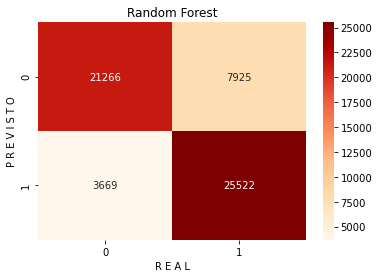

In [54]:
#Matriz de confusão
sns.heatmap(confusion_matrix(y_teste, rf_pred_filtro), cmap='OrRd', annot=True, fmt='2.0f')
plt.title('Random Forest')
plt.ylabel('P R E V I S T O')
plt.xlabel('R E A L')
plt.show()

In [55]:
#Acurácia, Sensibilidade positiva (VP/(VP+FN), Especificidade, Precisão, Recall, F1-Score
acuracia_rf_f = accuracy_score(y_teste,rf_pred_filtro)
especificidade_rf_f = specificity_score(y_teste,rf_pred_filtro)
precisao_rf_f = precision_score(y_teste,rf_pred_filtro)
recall_rf_f = recall_score(y_teste,rf_pred_filtro)
f1Score_rf_f = f1_score(y_teste,rf_pred_filtro)
curva_roc_escore_rf_f = roc_auc_score(y_teste,rf_pred_filtro)
kappa_rf_f = cohen_kappa_score(y_teste,rf_pred_filtro)
print(f'Acurácia:{round(acuracia_rf_f,2)}')
print(f'Especificidade:{round(especificidade_rf_f,2)}')
print(f'Precisão:{round(precisao_rf_f,2)}')
print(f'Recall ou Sensibilidade:{round(recall_rf_f,2)}')
print(f'F1-Score:{round(f1Score_rf_f,2)}')
print(f'Kappa:{round(kappa_rf_f,2)}')
print(f'Curva ROC:{round(curva_roc_escore_rf_f,2)}')

Acurácia:0.8
Especificidade:0.73
Precisão:0.76
Recall ou Sensibilidade:0.87
F1-Score:0.81
Kappa:0.6
Curva ROC:0.8


## Aplica o modelo de predição com Regressão Logística e Filter

In [56]:
#Executando o modelo
clf_rl_filtro = LogisticRegression(max_iter=2000)      
clr_rl_filtro = clf_rf_filtro.fit(X_train_filtro,y)

In [57]:
#Predição
rl_pred_filtro = clr_rl_filtro.predict(X_teste_filtro)

## Calculando as métricas

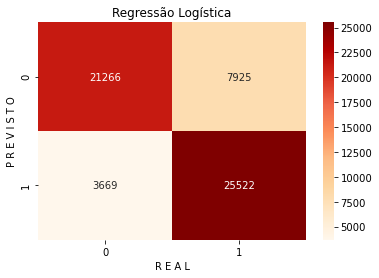

In [58]:
#Matriz de confusão
sns.heatmap(confusion_matrix(y_teste, rl_pred_filtro), cmap='OrRd', annot=True, fmt='2.0f')
plt.title('Regressão Logística')
plt.ylabel('P R E V I S T O')
plt.xlabel('R E A L')
plt.show()

In [59]:
#Acurácia, Sensibilidade positiva (VP/(VP+FN), Especificidade, Precisão, Recall, F1-Score
acuracia_rl_f = accuracy_score(y_teste,rl_pred_filtro)
especificidade_rl_f = specificity_score(y_teste,rl_pred_filtro)
precisao_rl_f = precision_score(y_teste,rl_pred_filtro)
recall_rl_f = recall_score(y_teste,rl_pred_filtro)
f1Score_rl_f = f1_score(y_teste,rl_pred_filtro)
curva_roc_escore_rl_f = roc_auc_score(y_teste,rl_pred_filtro)
kappa_rl_f = cohen_kappa_score(y_teste,rl_pred_filtro)
print(f'Acurácia:{round(acuracia_rl_f,2)}')
print(f'Especificidade:{round(especificidade_rl_f,2)}')
print(f'Precisão:{round(precisao_rf_f,2)}')
print(f'Recall ou Sensibilidade:{round(recall_rl_f,2)}')
print(f'F1-Score:{round(f1Score_rl_f,2)}')
print(f'Kappa:{round(kappa_rl_f,2)}')
print(f'Curva ROC:{round(curva_roc_escore_rl_f,2)}')

Acurácia:0.8
Especificidade:0.73
Precisão:0.76
Recall ou Sensibilidade:0.87
F1-Score:0.81
Kappa:0.6
Curva ROC:0.8


## Curva ROC

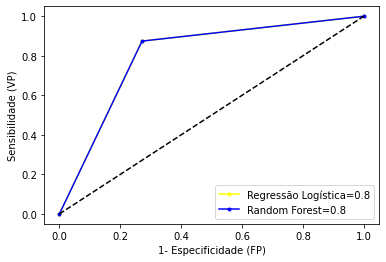

In [67]:
rfp_rl_f, rvp_rl_f,lim4 = roc_curve(y_teste,rl_pred_filtro)
rfp_rf_f, rvp_rf_f,lim5 = roc_curve(y_teste,rf_pred_filtro)
pyplot.plot(rfp_rl_f, rvp_rl_f, marker='.', label='Regressão Logística='+str(round(curva_roc_escore_rl_f,2)),color='yellow')
pyplot.plot(rfp_rf_f, rvp_rf_f, marker='.', label='Random Forest='+str(round(curva_roc_escore_rf_f,2)),color='blue')
pyplot.plot([0, 1], [0, 1], color='black', linestyle='--')
# alterando o nome dos eixos
pyplot.xlabel('1- Especificidade (FP)')
pyplot.ylabel('Sensibilidade (VP)')
pyplot.legend()
# Mostrando o gráfico
pyplot.show()

## Análise por Feature Importance (Método Filtro)

In [71]:
colNames = dadosTreino.columns.tolist()

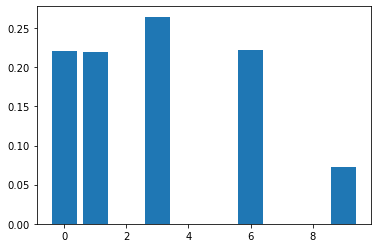

In [73]:
from sklearn.datasets import make_classification
from sklearn.ensemble import RandomForestClassifier
from matplotlib import pyplot
# define the model
model = RandomForestClassifier()
# fit the model
model.fit(X_train_filtro, y)
# get importance
importance = model.feature_importances_
# summarize feature importance
#for i,v in enumerate(importance):
 #    print('Feature %s - score %.5f' % (colNames[cols[i]], v) )
     #print('Feature: %0d, Score: %.5f' % (i,v))
# plot feature importance
pyplot.bar([x for x in range(len(importance))], importance)
pyplot.show()